# Elastic Net — Plantilla de experimento

**Cómo usar este cuaderno**
1. Edita la celda **CONFIGURACIÓN** con el nombre del experimento, las Ys y las Xs.
2. Corre todas las celdas en orden (`Run All`).
3. Los resultados se exportan automáticamente al directorio configurado.

Cada paso del pipeline vive en `pipeline/stepXX_*.py` y puede modificarse de forma independiente.

In [1]:
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# ── Rutas del proyecto ────────────────────────────────────────────────────────
# Sube hasta encontrar paths.yml (funciona desde cualquier subdirectorio)
_here = Path().resolve()
_root = _here
while not (_root / 'paths.yml').exists() and _root.parent != _root:
    _root = _root.parent

with open(_root / 'paths.yml') as f:
    _paths = yaml.safe_load(f)

raw       = Path(_paths['data']['raw'])
temp      = Path(_paths['data']['temp'])
processed = Path(_paths['data']['processed'])
model_out = Path(_paths['outputs']['model'])

# ── Importar pipeline ─────────────────────────────────────────────────────────
# El paquete pipeline/ debe estar en el mismo directorio que este notebook
sys.path.insert(0, str(_here))

from pipeline import (
    load_data,
    analyze_target,
    create_temporal_splits,
    prepare_features,
    impute_missing,
    scale_features,
    tune_hyperparameters,
    optimize_threshold,
    evaluate_model,
    get_coefficients,
    export_results,
)

print('✓ Pipeline importado correctamente')

✓ Pipeline importado correctamente


---
## CONFIGURACIÓN
**Edita esta celda antes de correr el experimento.**

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# IDENTIFICACIÓN DEL EXPERIMENTO
# ─────────────────────────────────────────────────────────────────────────────
EXPERIMENT_NAME = 'elasticnet_02'   # Prefijo de los archivos de salida

# ─────────────────────────────────────────────────────────────────────────────
# RUTAS
# ─────────────────────────────────────────────────────────────────────────────
DATA_PATH   = processed / 'db.parquet'
RESULTS_DIR = model_out   # Carpeta donde se guardan métricas y coeficientes

# ─────────────────────────────────────────────────────────────────────────────
# COLUMNAS CLAVE
# ─────────────────────────────────────────────────────────────────────────────
TARGET_COL       = 'atypical_violence_t_02'  # ← VARIABLE Y
TIME_COL         = 'quarter'            # Formato 'YYYYQN'
MUNICIPALITY_COL = 'mun_code'

# ─────────────────────────────────────────────────────────────────────────────
# SELECCIÓN DE VARIABLES X

# OPCIÓN B — Selección explícita (descomenta y lista tus Xs)
FEATURE_COLS = [
    'population',
    'dept_code',
    'women_share',
    'petroleo_crudo_median',
    'cafe_arabica_median',
    'oro_median',
    'covid',
    'covid_d',
    'ia_r1',
    'ia_r2',
    'ia_r3',
    'ia_r4',
    'igc_r1',
    'igc_r2',
    'igc_r3',
    'igc_r4',
    'iif_r1',
    'iif_r2',
    'iif_r3',
    'iif_r4',
    't_01_r1',
    't_01_r2',
    't_01_r3',
    't_01_r4',
    't_02_r1',
    't_02_r2',
    't_02_r3',
    't_02_r4',
    't_03_r1',
    't_03_r2',
    't_03_r3',
    't_03_r4',
    't_04_r1',
    't_04_r2',
    't_04_r3',
    't_04_r4',
    't_05_r1',
    't_05_r2',
    't_05_r3',
    't_05_r4',
    't_07_r1',
    't_07_r2',
    't_07_r3',
    't_07_r4',
    't_08_r1',
    't_08_r2',
    't_08_r3',
    't_08_r4',
    't_09_r1',
    't_09_r2',
    't_09_r3',
    't_09_r4',
    't_10_r1',
    't_10_r2',
    't_10_r3',
    't_10_r4',
    't_11_r1',
    't_11_r2',
    't_11_r3',
    't_11_r4',
    't_12_r1',
    't_12_r2',
    't_12_r3',
    't_12_r4',
    't_13_r1',
    't_13_r2',
    't_13_r3',
    't_13_r4',
    't_14_r1',
    't_14_r2',
    't_14_r3',
    't_14_r4',
    't_15_r1',
    't_15_r2',
    't_15_r3',
    't_15_r4',
    't_16_r1',
    't_16_r2',
    't_16_r3',
    't_16_r4',
    't_17_r1',
    't_17_r2',
    't_17_r3',
    't_17_r4',
    'coca',
    'amapola', 
    'y_corr', 
    'y_corr_tribut_IyC', 
    'DF_ing_func', 
    'DF_deuda',
    'DF_desemp_fisc', 
    's11_total', 
    'docen_total', 
    'alumn_total', 
    'nbi_2005',
    'nbi_2018', 
    'IPM_2005', 
    'IPM_2018',
    'ipm_ledu_p_2005',
    'ipm_ledu_p_2018', 
    'ipm_analf_p_2005', 
    'ipm_analf_p_2018',
    'ipm_asisescu_p_2005', 
    'ipm_asisescu_p_2018', 
    'ipm_rezagoescu_p_2005',
    'ipm_rezagoescu_p_2018', 
    'ipm_serv_pinf_p_2005', 
    'ipm_serv_pinf_p_2018',
    'ipm_ti_p_2005', 
    'ipm_ti_p_2018', 
    'ipm_templeof_p_2005',
    'ipm_templeof_p_2018', 
    'ipm_assalud_p_2005', 
    'ipm_assalud_p_2018',
    'ipm_accsalud_p_2005', 
    'ipm_accsalud_p_2018', 
    'ipm_accagua_p_2005',
    'ipm_accagua_p_2018', 
    'ipm_excretas_p_2005', 
    'ipm_excretas_p_2018',
    'ipm_pisos_p_2005', 
    'ipm_pisos_p_2018', 
    'ipm_paredes_p_2005',
    'ipm_paredes_p_2018', 
    'ipm_hacinam_p_2005', 
    'ipm_hacinam_p_2018',
    'indrural', 
    'areaoficialkm2', 
    'altura', 
    'discapital', 
    'dismdo',
    'disbogota', 
    'distancia_mercado'
]
COLS_TO_EXCLUDE = None   # Se ignora cuando FEATURE_COLS está definida

# ─────────────────────────────────────────────────────────────────────────────
# SPLITS TEMPORALES
# ─────────────────────────────────────────────────────────────────────────────
TRAIN_PROP = 0.70
VAL_PROP   = 0.15
TEST_PROP  = 0.15

# Splits por años específicos (descomenta para usar)
# USE_YEAR_SPLITS   = True
# TRAIN_END_YEAR    = 2018 ; TRAIN_END_QUARTER = 4
# VAL_END_YEAR      = 2020 ; VAL_END_QUARTER   = 4
USE_YEAR_SPLITS = False

# ─────────────────────────────────────────────────────────────────────────────
# HIPERPARÁMETROS
# ─────────────────────────────────────────────────────────────────────────────
PARAM_GRID = {
    'C':        [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}
N_CV_SPLITS   = 5
CV_SCORING    = 'f1'          # 'f1' | 'average_precision' | 'roc_auc'
RANDOM_STATE  = 42

# ─────────────────────────────────────────────────────────────────────────────
# THRESHOLD
# ─────────────────────────────────────────────────────────────────────────────
THRESHOLD_RANGE    = (0.1, 0.9)
THRESHOLD_STEP     = 0.05
THRESHOLD_METRIC   = 'f1'     # Métrica a maximizar al elegir el threshold

# ─────────────────────────────────────────────────────────────────────────────
# IMPUTACIÓN
# ─────────────────────────────────────────────────────────────────────────────
NUMERIC_STRATEGY      = 'median'
CATEGORICAL_STRATEGY  = 'most_frequent'

print(f'✓ Configuración lista  |  Experimento: {EXPERIMENT_NAME}')
print(f'  Target  : {TARGET_COL}')
print(f'  X mode  : {"explícita" if FEATURE_COLS else "por exclusión"}')
print(f'  Splits  : {TRAIN_PROP:.0%} / {VAL_PROP:.0%} / {TEST_PROP:.0%}')

✓ Configuración lista  |  Experimento: elasticnet_02
  Target  : atypical_violence_t_02
  X mode  : explícita
  Splits  : 70% / 15% / 15%


---
## Paso 1 — Cargar datos

In [3]:
df = load_data(DATA_PATH, time_col=TIME_COL, municipality_col=MUNICIPALITY_COL)
df.head(3)

Cargando datos desde: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/data/processed/db.parquet
✓ Datos cargados: 26,904 filas × 182 columnas
Rango temporal : 2017Q1 → 2022Q4
Periodos únicos: 24 | Municipios: 1121


,mun_code,quarter,population,women_share,petroleo_crudo_mean,petroleo_crudo_median,cafe_arabica_mean,cafe_arabica_median,oro_mean,oro_median,...,areaoficialkm2,altura,discapital,dismdo,disbogota,distancia_mercado,dept_code,año,trimestre,periodo_num
0,05001,2017Q1,2368047.0,0.52995,51.781452,52.690001,144.53629,143.875,1219.658067,1224.150024,...,6075.134367,1475.0,0.000000,0.000000,264.33902,0.000000,05,2017,1,20171
1,05002,2017Q1,20485.0,0.48250,51.781452,52.690001,144.53629,143.875,1219.658067,1224.150024,...,41.315895,2275.0,58.200874,58.200874,209.00545,16.083084,05,2017,1,20171
2,05004,2017Q1,2640.0,0.46364,51.781452,52.690001,144.53629,143.875,1219.658067,1224.150024,...,8.972696,1900.0,63.854633,63.854633,326.94080,49.629030,05,2017,1,20171


---
## Paso 2 — Análisis de la variable objetivo

ANÁLISIS DE VARIABLE OBJETIVO: 'atypical_violence_t_02'
  Clase 1 (positivo): 535  (1.99%)
  Clase 0 (negativo): 26,369  (98.01%)
  Desbalance        : 49.29:1
⚠️  Desbalance EXTREMO (<5%). Considerar SMOTE u otras técnicas.


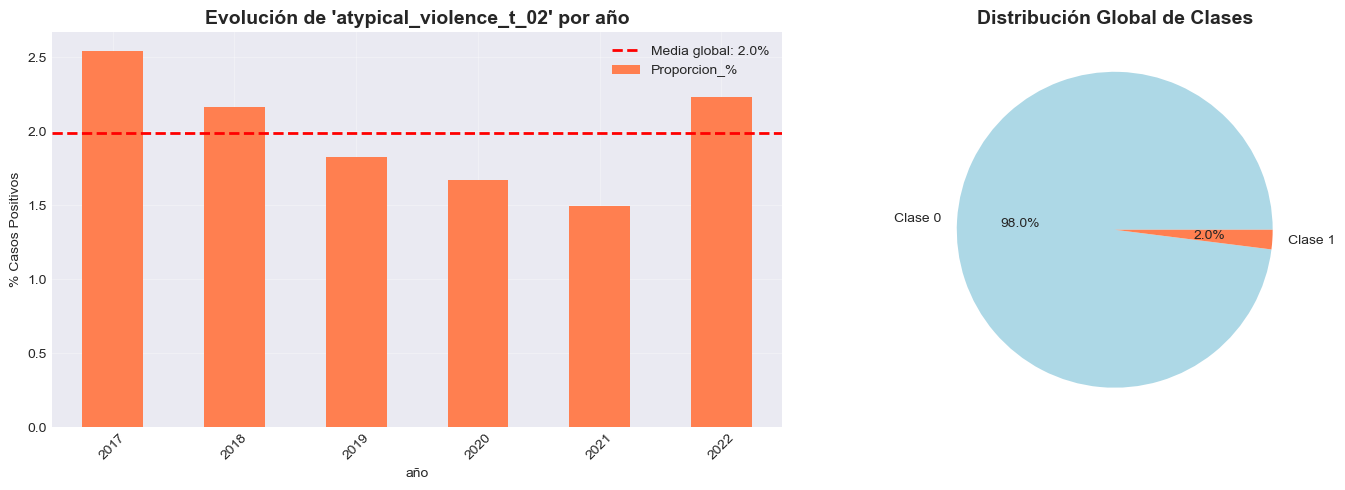

In [4]:
target_stats = analyze_target(df, TARGET_COL, time_group_col='año', plot=True)

---
## Paso 3 — Splits temporales

In [5]:
splits = create_temporal_splits(
    df,
    time_col       = TIME_COL,
    train_prop     = TRAIN_PROP,
    val_prop       = VAL_PROP,
    test_prop      = TEST_PROP,
    use_year_splits = USE_YEAR_SPLITS,
    # Descomenta si USE_YEAR_SPLITS=True:
    # train_end_year=TRAIN_END_YEAR, train_end_quarter=TRAIN_END_QUARTER,
    # val_end_year=VAL_END_YEAR,   val_end_quarter=VAL_END_QUARTER,
)

train_mask = splits['train_mask']
val_mask   = splits['val_mask']
test_mask  = splits['test_mask']

✓ Splits por proporciones (70%/15%/15%):
  Train: 16 periodos  (2017Q1 → 2020Q4)  17,936 obs (66.7%)
  Val  :  4 periodos  (2021Q1 → 2021Q4)  4,484 obs (16.7%)
  Test :  4 periodos  (2022Q1 → 2022Q4)  4,484 obs (16.7%)
✓ Sin overlap


---
## Paso 4 — Preparar features

In [6]:
X, y, feature_cols = prepare_features(
    df,
    target_col       = TARGET_COL,
    municipality_col = MUNICIPALITY_COL,
    time_col         = TIME_COL,
    cols_to_exclude  = COLS_TO_EXCLUDE,
    feature_cols     = FEATURE_COLS,
)

# Aplicar splits
X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
X_val,   y_val   = X[val_mask].copy(),   y[val_mask].copy()
X_test,  y_test  = X[test_mask].copy(),  y[test_mask].copy()

print(f'\nFormas: train={X_train.shape} | val={X_val.shape} | test={X_test.shape}')
for name, yy in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f'  {name}: prevalencia={yy.mean():.2%}')

FEATURES DEL MODELO
  Features seleccionadas : 133
  Target                 : 'atypical_violence_t_02'  (prevalencia: 1.99%)

  Variables:
      1. population
      2. dept_code
      3. women_share
      4. petroleo_crudo_median
      5. cafe_arabica_median
      6. oro_median
      7. covid
      8. covid_d
      9. ia_r1
     10. ia_r2
     11. ia_r3
     12. ia_r4
     13. igc_r1
     14. igc_r2
     15. igc_r3
     16. igc_r4
     17. iif_r1
     18. iif_r2
     19. iif_r3
     20. iif_r4
     21. t_01_r1
     22. t_01_r2
     23. t_01_r3
     24. t_01_r4
     25. t_02_r1
     26. t_02_r2
     27. t_02_r3
     28. t_02_r4
     29. t_03_r1
     30. t_03_r2
     31. t_03_r3
     32. t_03_r4
     33. t_04_r1
     34. t_04_r2
     35. t_04_r3
     36. t_04_r4
     37. t_05_r1
     38. t_05_r2
     39. t_05_r3
     40. t_05_r4
     41. t_07_r1
     42. t_07_r2
     43. t_07_r3
     44. t_07_r4
     45. t_08_r1
     46. t_08_r2
     47. t_08_r3
     48. t_08_r4
     49. t_09_r1
     50.

---
## Paso 5 — Imputación

In [7]:
X_train, X_val, X_test, imputers = impute_missing(
    X_train, X_val, X_test,
    numeric_strategy     = NUMERIC_STRATEGY,
    categorical_strategy = CATEGORICAL_STRATEGY,
)

Columnas numéricas: 132 | Categóricas: 1
Valores faltantes en train: 0
✓ Sin valores faltantes, no se requiere imputación
NaNs restantes: 0


---
## Paso 6 — Estandarización

In [8]:
X_train_sc, X_val_sc, X_test_sc, scaler = scale_features(
    X_train, X_val, X_test, feature_cols
)

✓ Estandarización sin leakage
  Verificación train → Media ~0: 1.39e-15 | Std ~1: 2.79e-05


---
## Paso 7 — Búsqueda de hiperparámetros

In [9]:
import pandas as pd

X_tv = pd.concat([X_train_sc, X_val_sc])
y_tv = pd.concat([y_train, y_val])

best_model, cv_results = tune_hyperparameters(
    X_tv, y_tv,
    param_grid   = PARAM_GRID,
    n_cv_splits  = N_CV_SPLITS,
    scoring      = CV_SCORING,
    random_state = RANDOM_STATE,
)

GridSearchCV: 30 combinaciones × 5 folds | métrica: f1
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max


✓ Mejores hiperparámetros:
  C: 0.1
  l1_ratio: 0.7
  Mejor f1 (CV): 0.0903

Top 5 configuraciones:
 param_C  param_l1_ratio  mean_test_score  std_test_score
     0.1             0.7         0.090316        0.028858
     0.1             0.5         0.089929        0.029631
     0.1             0.9         0.088940        0.027069
     1.0             0.7         0.088855        0.033890
     1.0             0.1         0.088825        0.033607


---
## Paso 8 — Optimización de threshold

Threshold óptimo (f1): 0.75
  F1: 0.1801 | Precision: 0.1137 | Recall: 0.4328


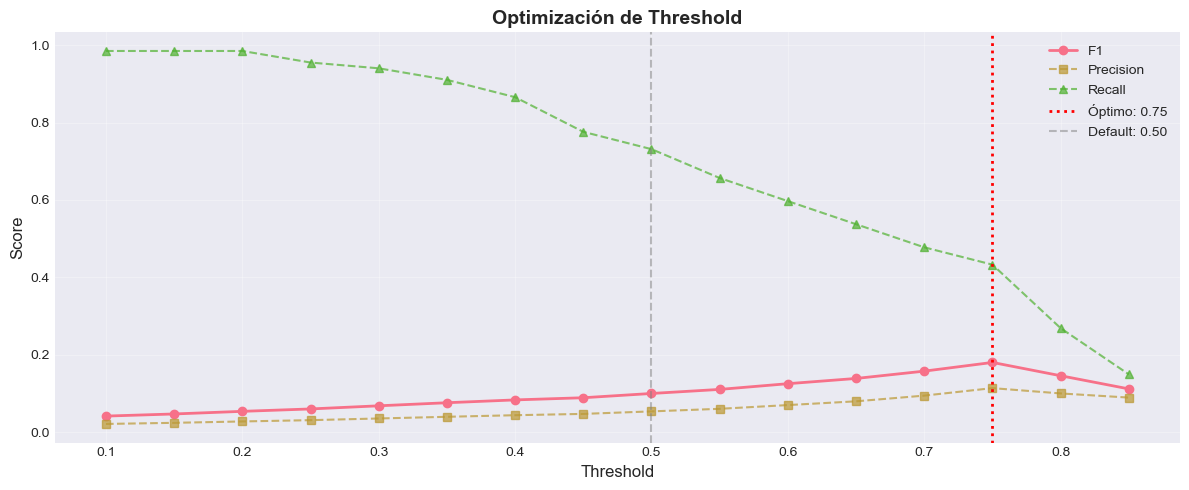

In [10]:
best_threshold, threshold_df = optimize_threshold(
    best_model, X_val_sc, y_val,
    threshold_range  = THRESHOLD_RANGE,
    threshold_step   = THRESHOLD_STEP,
    optimize_metric  = THRESHOLD_METRIC,
    plot             = True,
)

---
## Paso 9 — Evaluación en test

EVALUACIÓN FINAL EN TEST SET
  AUPRC                 : 0.1270
  AUROC                 : 0.8071
  Balanced_Accuracy     : 0.7043
  F1_Score              : 0.1815
  Precision             : 0.1109
  Recall                : 0.5000
  Cohen_Kappa           : 0.1505
  Threshold             : 0.7500

Classification Report:
              precision    recall  f1-score   support

     Clase 0     0.9876    0.9085    0.9464      4384
     Clase 1     0.1109    0.5000    0.1815       100

    accuracy                         0.8994      4484
   macro avg     0.5492    0.7043    0.5640      4484
weighted avg     0.9680    0.8994    0.9294      4484



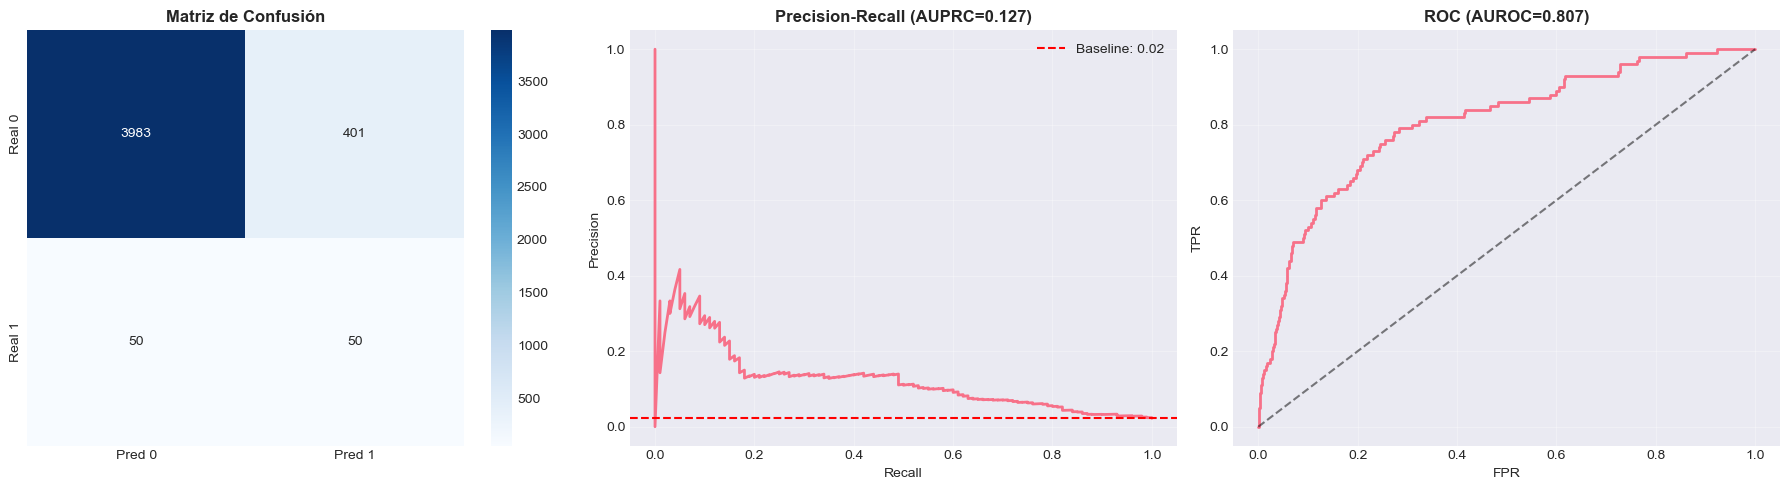

In [11]:
metrics, y_test_proba, y_test_pred = evaluate_model(
    best_model, X_test_sc, y_test,
    threshold = best_threshold,
    plot      = True,
)

---
## Paso 10 — Interpretabilidad

INTERPRETABILIDAD — COEFICIENTES
  Features activas    : 129 de 133
  Eliminadas (coef=0) : 4
  → ['ipm_templeof_p_2005', 'ipm_paredes_p_2018', 't_14_r2', 'ipm_ledu_p_2018']

Top 20 por magnitud:
             Feature  Coeficiente  Odds_Ratio
         alumn_total    -0.966900    0.380260
             t_15_r3    -0.590653    0.553966
    ipm_pisos_p_2005    -0.539329    0.583139
      DF_desemp_fisc    -0.519225    0.594981
  ipm_accagua_p_2005     0.444778    1.560144
         docen_total    -0.443663    0.641681
             t_15_r4    -0.437387    0.645721
    ipm_analf_p_2018    -0.390796    0.676518
            IPM_2018     0.368165    1.445081
              dismdo    -0.361089    0.696917
     ipm_ledu_p_2005    -0.348692    0.705610
             t_07_r1    -0.327692    0.720585
  ipm_accagua_p_2018    -0.319025    0.726857
              y_corr    -0.307463    0.735310
ipm_serv_pinf_p_2018    -0.299077    0.741502
           disbogota     0.293721    1.341410
 ipm_asisescu_p_2005  

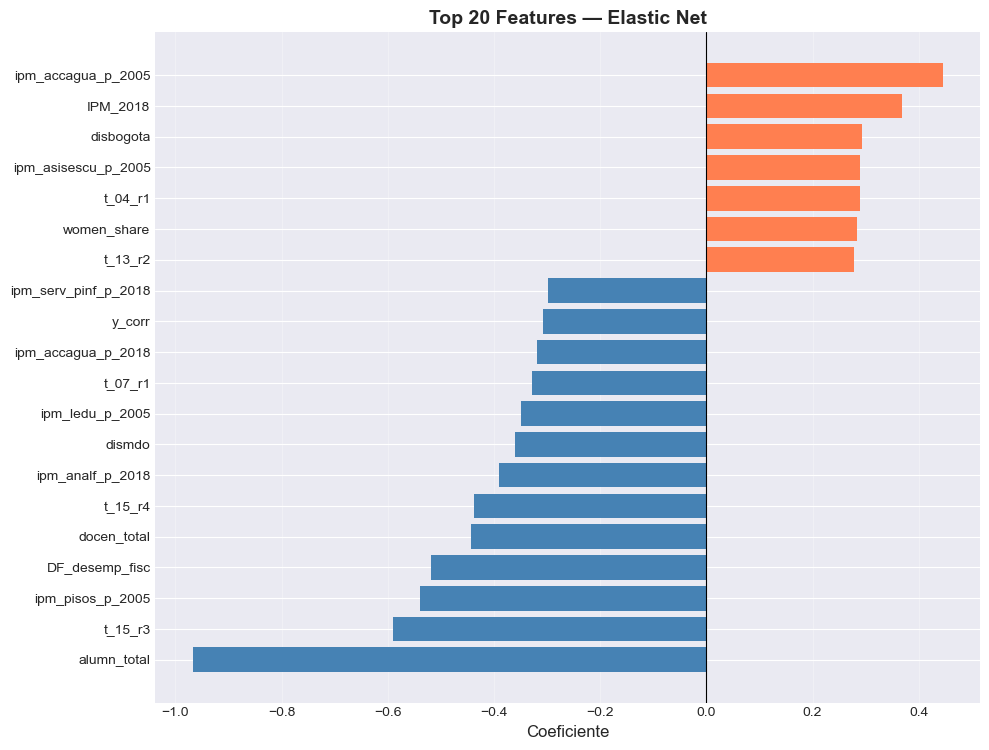

In [12]:
coeficientes = get_coefficients(best_model, feature_cols, top_n=20, plot=True)

---
## Paso 11 — Exportar resultados

In [13]:
extra = {
    'n_features':      len(feature_cols),
    'train_size':      len(y_train),
    'val_size':        len(y_val),
    'test_size':       len(y_test),
    'train_prev':      float(y_train.mean()),
    'val_prev':        float(y_val.mean()),
    'test_prev':       float(y_test.mean()),
    'best_C':          best_model.C,
    'best_l1_ratio':   best_model.l1_ratio,
    'cv_scoring':      CV_SCORING,
    'target_col':      TARGET_COL,
}

output_paths = export_results(
    results_dir     = RESULTS_DIR,
    experiment_name = EXPERIMENT_NAME,
    metrics         = metrics,
    coeficientes    = coeficientes,
    extra_info      = extra,
)

✓ Resultados exportados en: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/model
  Métricas     : elasticnet_02_metrics_20260219_064413.csv
  Coeficientes : elasticnet_02_coeficientes_20260219_064413.csv
